In [1]:
from MultivariateNormalDistribution import mvn

import itertools

from scipy import linalg
from sklearn import mixture
from sklearn import metrics
from sklearn import datasets
from sklearn import utils

import numpy as np
import numpy.random as rnd
import math

from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib as mpl


%matplotlib inline

In [2]:
#http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html
color_iter = itertools.cycle(['r', 'g', 'b', 'y',
                              'black'])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 2, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.xlim(-9., 5.)
    #plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    
def show_internal_number_representation(mvn):
    # Displays the internal representation that the MVN has of the learned number by reshaping
    # the learned mu and plotting it
    # Works only with digits datasets or other 8x8 data
    plt.figure(1, figsize=(3, 3))
    plt.imshow(mvn.mu.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

In [3]:
def predictOutcome(data, y, mvn_list, dimensions, verbose=False):
    out = []
    for i in range(0,len(data)):
        cur = np.transpose(data[i].reshape(1,dimensions))
        logliks = []
        for m in mvn_list:
            if m.updatedPrior: # In the beginning not all mvns are updated using MAP thats why we have to check
                logliks.append(m.logPosteriorPredictive(cur))
                #print("TRUE: add loglik for mvn       [{}]: {}".format(bla,m.logPosteriorPredictive(cur)))
            #else:
                #print("FALSE: no updated prior for mvn[{}], adding 0 to logliks".format(bla))
                #logliks.append(0)
        if verbose:
            print("predicted: {}, acutal: {}".format(logliks.index(max(logliks)), y[i]))
        if len(logliks) > 0:
            out.append(logliks.index(max(logliks)))
    #print("===done===")
    return out
def concatenate_all(input_list, axis=0):
    out = input_list[0]
    for i in range(1,len(input_list)):
        out = np.concatenate((out, input_list[i]),axis=axis)
    return out

===================== prepare data ================================
===================== learn ================================
0/144


/home/oli/Workspace/MultivariateNormalDistribution/MultivariateNormalDistribution/mtsd.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  logdet = math.log(self.__sigma_det)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


10/144
20/144
30/144
40/144
50/144
60/144
70/144
80/144
90/144
100/144
110/144
120/144
130/144
140/144
===================== plot ================================


Text(0,0.5,'F1-score')

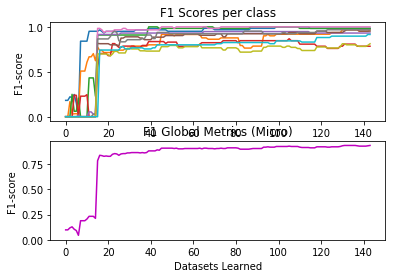

In [4]:
#np.set_printoptions(threshold=np.nan)
#=======DEBUG===========
prior_data_size = 5
test_data_size = 30

iris = datasets.load_iris()
digits = datasets.load_digits()
boston = datasets.load_boston()

X = digits.data # Features 
y = digits.target # Targets
#X = iris.data
#y = iris.target
#X = boston.data
#y = boston.target
target_number = len(set(y)) # Number of different targets


dimensions = np.shape(X[1])[0] # Dimension is number of features (64 in the case of digits dataset)
dataset_size = len(digits.target) # Determine the dataset size and calculate the size of the training data
# Generate training and test data for first type of iris

# Only take part of the dimensions
X = X[:,range(0,dimensions)]
print("===================== prepare data ================================")
# Lists for training data
X_training = []
y_training = []
# Lists for test data
X_testing = []
y_testing = []
# Lists for mvn related variables
priors = []
mvns = []
training_data_size = []
for i in range(0,target_number):
    # Get all datasets from the same class
    X_type_1 = X[y==i]
    y_type_1 = y[y==i]
    # Prepare prior dataset
    X_type_1_prior = np.transpose((X_type_1[range(0,prior_data_size)]))
    # Prepare training dataset
    X_type_1_train = np.transpose(X_type_1[range(prior_data_size,len(X_type_1)-test_data_size),:])
    X_training.append(np.transpose(X_type_1_train))
    y_type_1_train = np.transpose(y_type_1[range(prior_data_size,len(X_type_1)-test_data_size)])
    y_training.append(y_type_1_train)
    # Prepare test dataset
    X_type_1_test = np.transpose(X_type_1[range(len(X_type_1)-test_data_size,len(X_type_1)),:])
    X_testing.append(np.transpose(X_type_1_test))
    y_type_1_test = y_type_1[range(len(X_type_1)-test_data_size,len(X_type_1))]
    y_testing.append(y_type_1_test)
    # Calculate prior for the mvn
    mvn_prior_1 = mvn.MultivariateNormalDistribution(dimensions=dimensions, name="prior1")
    mvn_prior_1.MLE(X_type_1_prior)
    priors.append(mvn_prior_1)
    # Create the MVN with prior
    nu0 = dimensions+2;
    S_0 = np.multiply(np.diag(np.diag(mvn_prior_1.sigma)),nu0)
    m_0 = mvn_prior_1.mu
    kappa0 = prior_data_size
    mvn_type_1 = mvn.MultivariateNormalDistribution(dimensions=dimensions, m0=m_0, S0=S_0 , kappa=kappa0, nu=nu0, name="MVN1")
    mvns.append(mvn_type_1)
    # Build a list that contains the number of samples per class
    training_data_size.append(len(np.transpose(X_type_1_train)))

print("===================== learn ================================")
# Prepare training data from all classes
X_training = concatenate_all(X_training)
y_training = concatenate_all(y_training)
X_testing = concatenate_all(X_testing)
y_testing = concatenate_all(y_testing)

# Shuffle Datasets
X_training, y_training = utils.shuffle(X_training,y_training)

# Lists to store f1 score information
f_scores = []
f1_list = []
for j in range(0,int(len(X_training)/10)):
    for i in range(0, target_number):
        if y_training[j] == i:
            X_train = np.transpose(X_training[i])
            mvns[i].MAP(X_training[j].reshape((dimensions,1)))
            # Measure performance, track f1 scores
            y_pred = predictOutcome(X_testing, y_testing,mvns, dimensions)
            f1 = metrics.f1_score(y_testing, y_pred, average=None)
            f_scores.append(f1)
            f1_list.append(metrics.f1_score(y_testing, y_pred, average='micro'))
    if j%10==0:
        print("{}/{}".format(j,int(len(X_training)/10)))
print("===================== plot ================================")
#show_internal_number_representation(mvns[8])
            
f_scores = np.transpose(np.array(f_scores))
#show_internal_number_representation(mvns[1])
x_tick = range(0,len(f_scores[0]))
fig = plt.figure()
# Plot f1 score for each class
plt.subplot(211)
plt.title("F1 Scores per class")
plt.xlabel("Datasets Learned")
plt.ylabel("F1-score")
for j in range(0, target_number):
    plt.plot(x_tick,(f_scores[j]))
# Plot the f1 score globally by counting the total true positives, false negatives and false positives.
plt.subplot(212)
plt.plot(x_tick,f1_list,color='m')
plt.title("F1 Global Metrics (Micro)")
plt.xlabel("Datasets Learned")
plt.ylabel("F1-score")



In [ ]:
# Test the mvn classifier
print(X_testing)
y_pred = predictOutcome(X_testing, y_testing,mvns, dimensions,verbose=True)
print(metrics.f1_score(y_testing, y_pred, average=None))
for i in range(0,target_number):
    show_internal_number_representation(mvns[i])